<a href="https://colab.research.google.com/github/ojw92/NLP-for-Text-Classification/blob/main/BERT_VOC_loc_met.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BERT Practice
#### v. 20230828

In [1]:
# 20230825 Pick up from here later :

# ROC curve for BERT : https://towardsdatascience.com/practical-introduction-to-transformer-models-bert-4715ed0deede
# Interesting read on BERT semantic similarity : https://christianbernecker.medium.com/nlp-similarity-use-pretrained-word-embeddings-for-semantic-similarity-search-with-bert-4beaf7b6a148
# Cool T-SNE graphs : https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d


# https://www.run.ai/guides/machine-learning-operations
# https://www.run.ai/guides/machine-learning-engineering/machine-learning-workflow
# https://www.run.ai/guides/machine-learning-engineering/machine-learning-automation

# https://research.google.com/colaboratory/local-runtimes.html
# https://stackoverflow.com/questions/60235353/docker-is-not-running-on-colab

"""
https://www.youtube.com/watch?v=0S81koZpwPA
install CUDA Toolkit, install WSL2, check for cuda availability!!
https://discuss.tensorflow.org/t/fail-to-use-4070ti/17447
Ubuntu vs WSL2 for Tensorflow??
"""


'\nhttps://www.youtube.com/watch?v=0S81koZpwPA\ninstall CUDA Toolkit, install WSL2, check for cuda availability!!\nhttps://discuss.tensorflow.org/t/fail-to-use-4070ti/17447\nUbuntu vs WSL2 for Tensorflow??\n'

In [2]:
# pip3 install torch torchvision torchaudio     # for PyTorch without GPU, just CPU


In [3]:
# Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`
# https://stackoverflow.com/questions/76448287/how-can-i-solve-importerror-using-the-trainer-with-pytorch-requires-accele
# Most probably you might have an ImportError at the first line if accelerate is not already installed when you installed transformers.

!pip install -U accelerate
!pip install transformers -U
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117    # install PyTorch

import accelerate
import transformers

transformers.__version__, accelerate.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu117


('4.32.1', '0.22.0')

In [4]:
# Check if the GPU can be detected
# tensorflow-gpu has been removed. tensorflow package supports GPU accelerated operations via Nvidia CUDA.
import tensorflow as tf

device_name = tf.test.gpu_device_name()              # '/device:GPU:0' means GPU is enabled
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import torch
# torch.cuda.is_available = lambda : False
""" # old way
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
"""
# use my own GPU to train; move tensor to my GPU; https://www.run.ai/guides/gpu-deep-learning/pytorch-gpu
if torch.cuda.is_available():
   dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(device)
t1 = torch.zeros(4,3)
print(t1)
t1 = t1.to(device)
print(t1)

cuda:0
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In [6]:
print(tf.config.list_physical_devices('GPU'))

# device_lib.list_local_devices()

torch.cuda.is_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [7]:
# https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09

# Make sure the same device is used for tensor allocation during all operations

a = t1.get_device()                    # returns the index of the GPU on which the tensor resides
b = torch.tensor(t1.shape).to(dev)     # use this index to direct placement for new tensors

# torch.cuda.set_device(  {GPU ID}  )     # alternative method to tensor placement

print(a)
print(b)

0
tensor([4, 3], device='cuda:0')


In [8]:
# https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09

# Check running environment info regarding Cuda and devices

import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )

from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
__pyTorch VERSION: 2.0.1+cu118
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [9]:

# And check device information of my graphics driver

!pip install pycuda
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name()   # '0' is the id of my GPU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661265 sha256=fe9b582aa39ef8d7e4f673ab628fe4c0ad1c138581c63ff4d2ad3946a44b3248
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
Successfully built pycuda


'Tesla T4'

In [10]:
!cat /proc/meminfo            # check memory resources available

MemTotal:       13294252 kB
MemFree:         4856204 kB
MemAvailable:    9351836 kB
Buffers:           83500 kB
Cached:          4612784 kB
SwapCached:            0 kB
Active:           829784 kB
Inactive:        7135912 kB
Active(anon):       6136 kB
Inactive(anon):  3282196 kB
Active(file):     823648 kB
Inactive(file):  3853716 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              5984 kB
Writeback:             0 kB
AnonPages:       3266380 kB
Mapped:          1114012 kB
Shmem:             18920 kB
KReclaimable:     118444 kB
Slab:             170136 kB
SReclaimable:     118444 kB
SUnreclaim:        51692 kB
KernelStack:        4928 kB
PageTables:        35624 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6647124 kB
Committed_AS:    4994288 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       77728 kB
VmallocChunk:          0 kB
Percpu:          

In [11]:
# install wandb for tracking data on dashboard
!pip install datasets wandb evaluate -qU
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/run_glue.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
--2023-08-31 17:12:45--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/run_glue.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.10

In [12]:
















# the run_glue.py script requires transformers dev
#!pip install -q git+https://github.com/huggingface/transformers

In [13]:
import wandb

# log in to have data synced to account
wandb.login()                         # uncomment to enter API key when this line runs

# log every trained model
%env WANDB_LOG_MODEL=true

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_LOG_MODEL=true


In [14]:

# https://github.com/PradipNichite/Youtube-Tutorials/blob/main/FineTune_BERT_Model_Youtube.ipynb

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# filter training data to desired dates (after 2022.2.22)
df = pd.read_csv('test.csv', index_col=0).drop_duplicates()
#df = df[df.columns[0:5]]

# filter training data to desired dates
from datetime import datetime, timedelta

df = df[df.Date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date() > datetime(2022,2,21).date())]

# For class imbalance, use roughly same ratio of R & N
# BERT doesn't need class imbalance addressed
# df = pd.concat([df[df.Class=='R'], df[df.Class=='N'].iloc[::3, :]])

# Reduce data to reduce training time to test features
# df22 = df22.sample(frac=0.01, random_state=5)




In [88]:
# Define Title + Content concatenator
from timeit import default_timer as timer
import re

def data_concat(df22, R_known=True):

    # Split the input dataframe into Text (Title + Contents) and Classes dataframes
    # input must have 3 columns of string entries (Title, Contents, and Classes)

    # check if every row entry of each column is string type (some are NaN, so no)
    # print(df22.applymap(lambda x : type(x).__name__).eq({'Title': 'str', 'Content': 'str', 'Class':'str'}))

    # convert NaN to empty strings (NaN -> str)
        # df22.apply(str) converts all columns to str, as well
    df22 = df22.replace(float('nan'), '', regex=True)

    # concatenate strings of title & content with a " " in between (1 body of text)
    df22['Text'] = df22['Title'] + " " + df22['Content']      # slicing DataFrame via .iloc[:,0] makes it a Series
    df22 = df22.loc[: , ['Text', 'Class']]    # so initialize it as a DataFrame. pd.DataFrame(some_Series) works

    if R_known == True:
    # R, r, YR = 1;     N, n, YN = 0
        R_cases = re.compile('R|YR|yy', re.IGNORECASE)
        N_cases = re.compile('N|YN', re.IGNORECASE)
        df22['Class'] = df22['Class'].replace(to_replace=R_cases, value=1)
        df22['Class'] = df22['Class'].replace(to_replace=N_cases, value=0)
    else:
        # R_known == False; prepping not yet classified data
        Y_N_cases = re.compile('Y|N', re.IGNORECASE)
        df22['Class'] = df22['Class'].replace(to_replace=Y_N_cases, value=0)     # all N's for simplicity

    df22['Class'] = df22['Class'].astype('int32')


    return df22


In [16]:
# combine title & content as text22, clean the text, then combine it with labels to a single df
df = data_concat(df)
df.head()

,Text,Class
452,Zfold 3 or S22 ultra Trying to decide between ...,0
453,S22 video cam Anyone tried out the video camer...,0
454,Thinking about trading my S21Ultra for S22+ Ev...,0
455,S21 Ultra vs S22+ Both phones are currently at...,0
456,"S21 or S22 Base/Standard Model Hey All,\n\nLoo...",0


In [17]:
df['Class'].value_counts()

0    21624
1     7297
Name: Class, dtype: int64

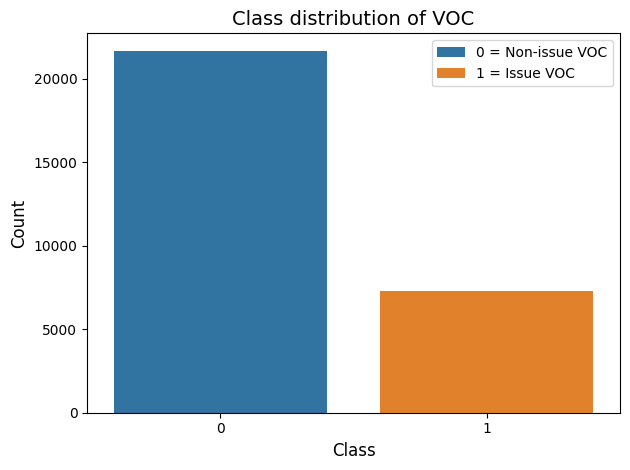

In [18]:
# Data Exploration - Histogram of Classes
sns.countplot(x=df['Class'], hue=df['Class'], dodge=False, data=df['Text'])
plt.title('Class distribution of VOC', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
"""
from matplotlib.patches import Rectangle
cmap = plt.get_cmap('jet')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [cmap(0.27), cmap(0.75)]]
plt.legend(handles, ['0 = Non-issue VOC', '1 = Issue VOC'])
"""
plt.legend(['0 = Non-issue VOC', '1 = Issue VOC'])
plt.tight_layout()
plt.show()

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (5.75, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

### Split data into training & validation sets

In [19]:
from sklearn.model_selection import train_test_split

X = df["Text"]          # originally list(df["Text"]). Keep an eye out for errors
y = df["Class"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,stratify=y)

In [20]:
len(X_train),len(X_val)

(26028, 2893)

In [21]:
# Data Exploration - use of the tf-idf algorithm to see which words in the corpus have play a key role in +/- classification (according to tf-idf)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#X_train = df['Text']
#y_train = df['Class']
min_df = 15       # consider words that occur at least this many times

# Tf-idf vectorization with bi-grams
print('==========     Tf-idf, 2-gram     ==========')
vect = TfidfVectorizer(min_df=min_df,
        ngram_range = (1,2),      # (min,max) n values for n-grams to be extract & created as features (default=1)
        ).fit(X_train)            # vect.fit(x).transform(x) = vect.fit_transform(x)
print("how many features are there? ", len(vect.get_feature_names_out()))
print("type of vect: ", type(vect))
print("vect: ", vect)

X_train_vectorized = vect.transform(X_train)
print("type of X_train_vectorized: ", type(X_train_vectorized))
print("shape of X_train_vectorized:", X_train_vectorized.shape)
#print("X_train_vectorized: ", X_train_vectorized)

# Initialize logistic regression model
tf_model = LogisticRegression(max_iter=10000)
tf_model.fit(X_train_vectorized, y_train)

feature_names = np.array(vect.get_feature_names_out())

# Print words with smallest & highest tf-idf scores. Higher score = more important, relevant word
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
print('\nSmallest tf-idf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tf-idf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

# Print words with smallest & highest coefficients. Larger coef = contributes more to classifying as 1
sorted_coef_index = tf_model.coef_[0].argsort()
print('\nSmallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

==========     Tf-idf, 2-gram     ==========
how many features are there?  17348
type of vect:  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
vect:  TfidfVectorizer(min_df=15, ngram_range=(1, 2))
type of X_train_vectorized:  <class 'scipy.sparse._csr.csr_matrix'>
shape of X_train_vectorized: (26028, 17348)

Smallest tf-idf:
['so didn' 'as someone' 'it though' 'thing the' 'plenty of' 'but decided'
 'again not' 'stuff and' 's22 however' 'plan with']

Largest tf-idf: 
['3x' 'fe' 'some' 'dex' 'philippines' 'heart' 'couple' 'hello' 's22u'
 'exynos']

Smallest Coefs:
['exynos' 'comment' 'oneui' 'one ui' 'how' 'beta' 'ui' 'case' 'for' 'you']

Largest Coefs: 
['issue' 'problem' 'fix' 'issues' 'when' 'not' 'won' 'keeps' 'not working'
 'randomly']


In [22]:
# Define a new function to draw a word map

import gensim
from sklearn.manifold import TSNE
import random

def semantic_similarity(X_train):

    # X_train should be a single-column DataFrame of preprocessed Title + Content (text22 or df22['Text'])
    X_train = X_train.apply(lambda x: gensim.utils.simple_preprocess(str(x)))
    # Train the word2vec model
    w2v_model = gensim.models.Word2Vec(X_train,
                                    vector_size=100,   # size of vectors desired
                                    window=5,  # # of words before & after target word to use as context
                                    min_count=2        # min_df
                                    )
    w2v_model.build_vocab(X_train)  # prepare the model vocabulary
    w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
    vocab_size, embedding_size = w2v_model.wv.vectors.shape

    n_samples = 250
    # Sample random words from model dictionary
    random_i = random.sample(range(vocab_size), n_samples)
    # def token2word(token):
    #     return w2v_model.wv.index_to_key[token]
    random_w = [w2v_model.wv.index_to_key[i] for i in random_i]

    # Generate Word2Vec embeddings of each word
    word_vecs = np.array([w2v_model.wv[w] for w in random_w])   # 'Word2Vec' object not subscriptable; use .wv

    # Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
    tsne = TSNE()
    tsne_e = tsne.fit_transform(word_vecs)

    # Plot t-SNE result
    plt.figure(figsize=(32, 32))
    plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

    for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
        plt.annotate(label,
                    xy=(x, y), xytext=(0, 15),
                    textcoords='offset points', ha='right', va='bottom',
                    bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

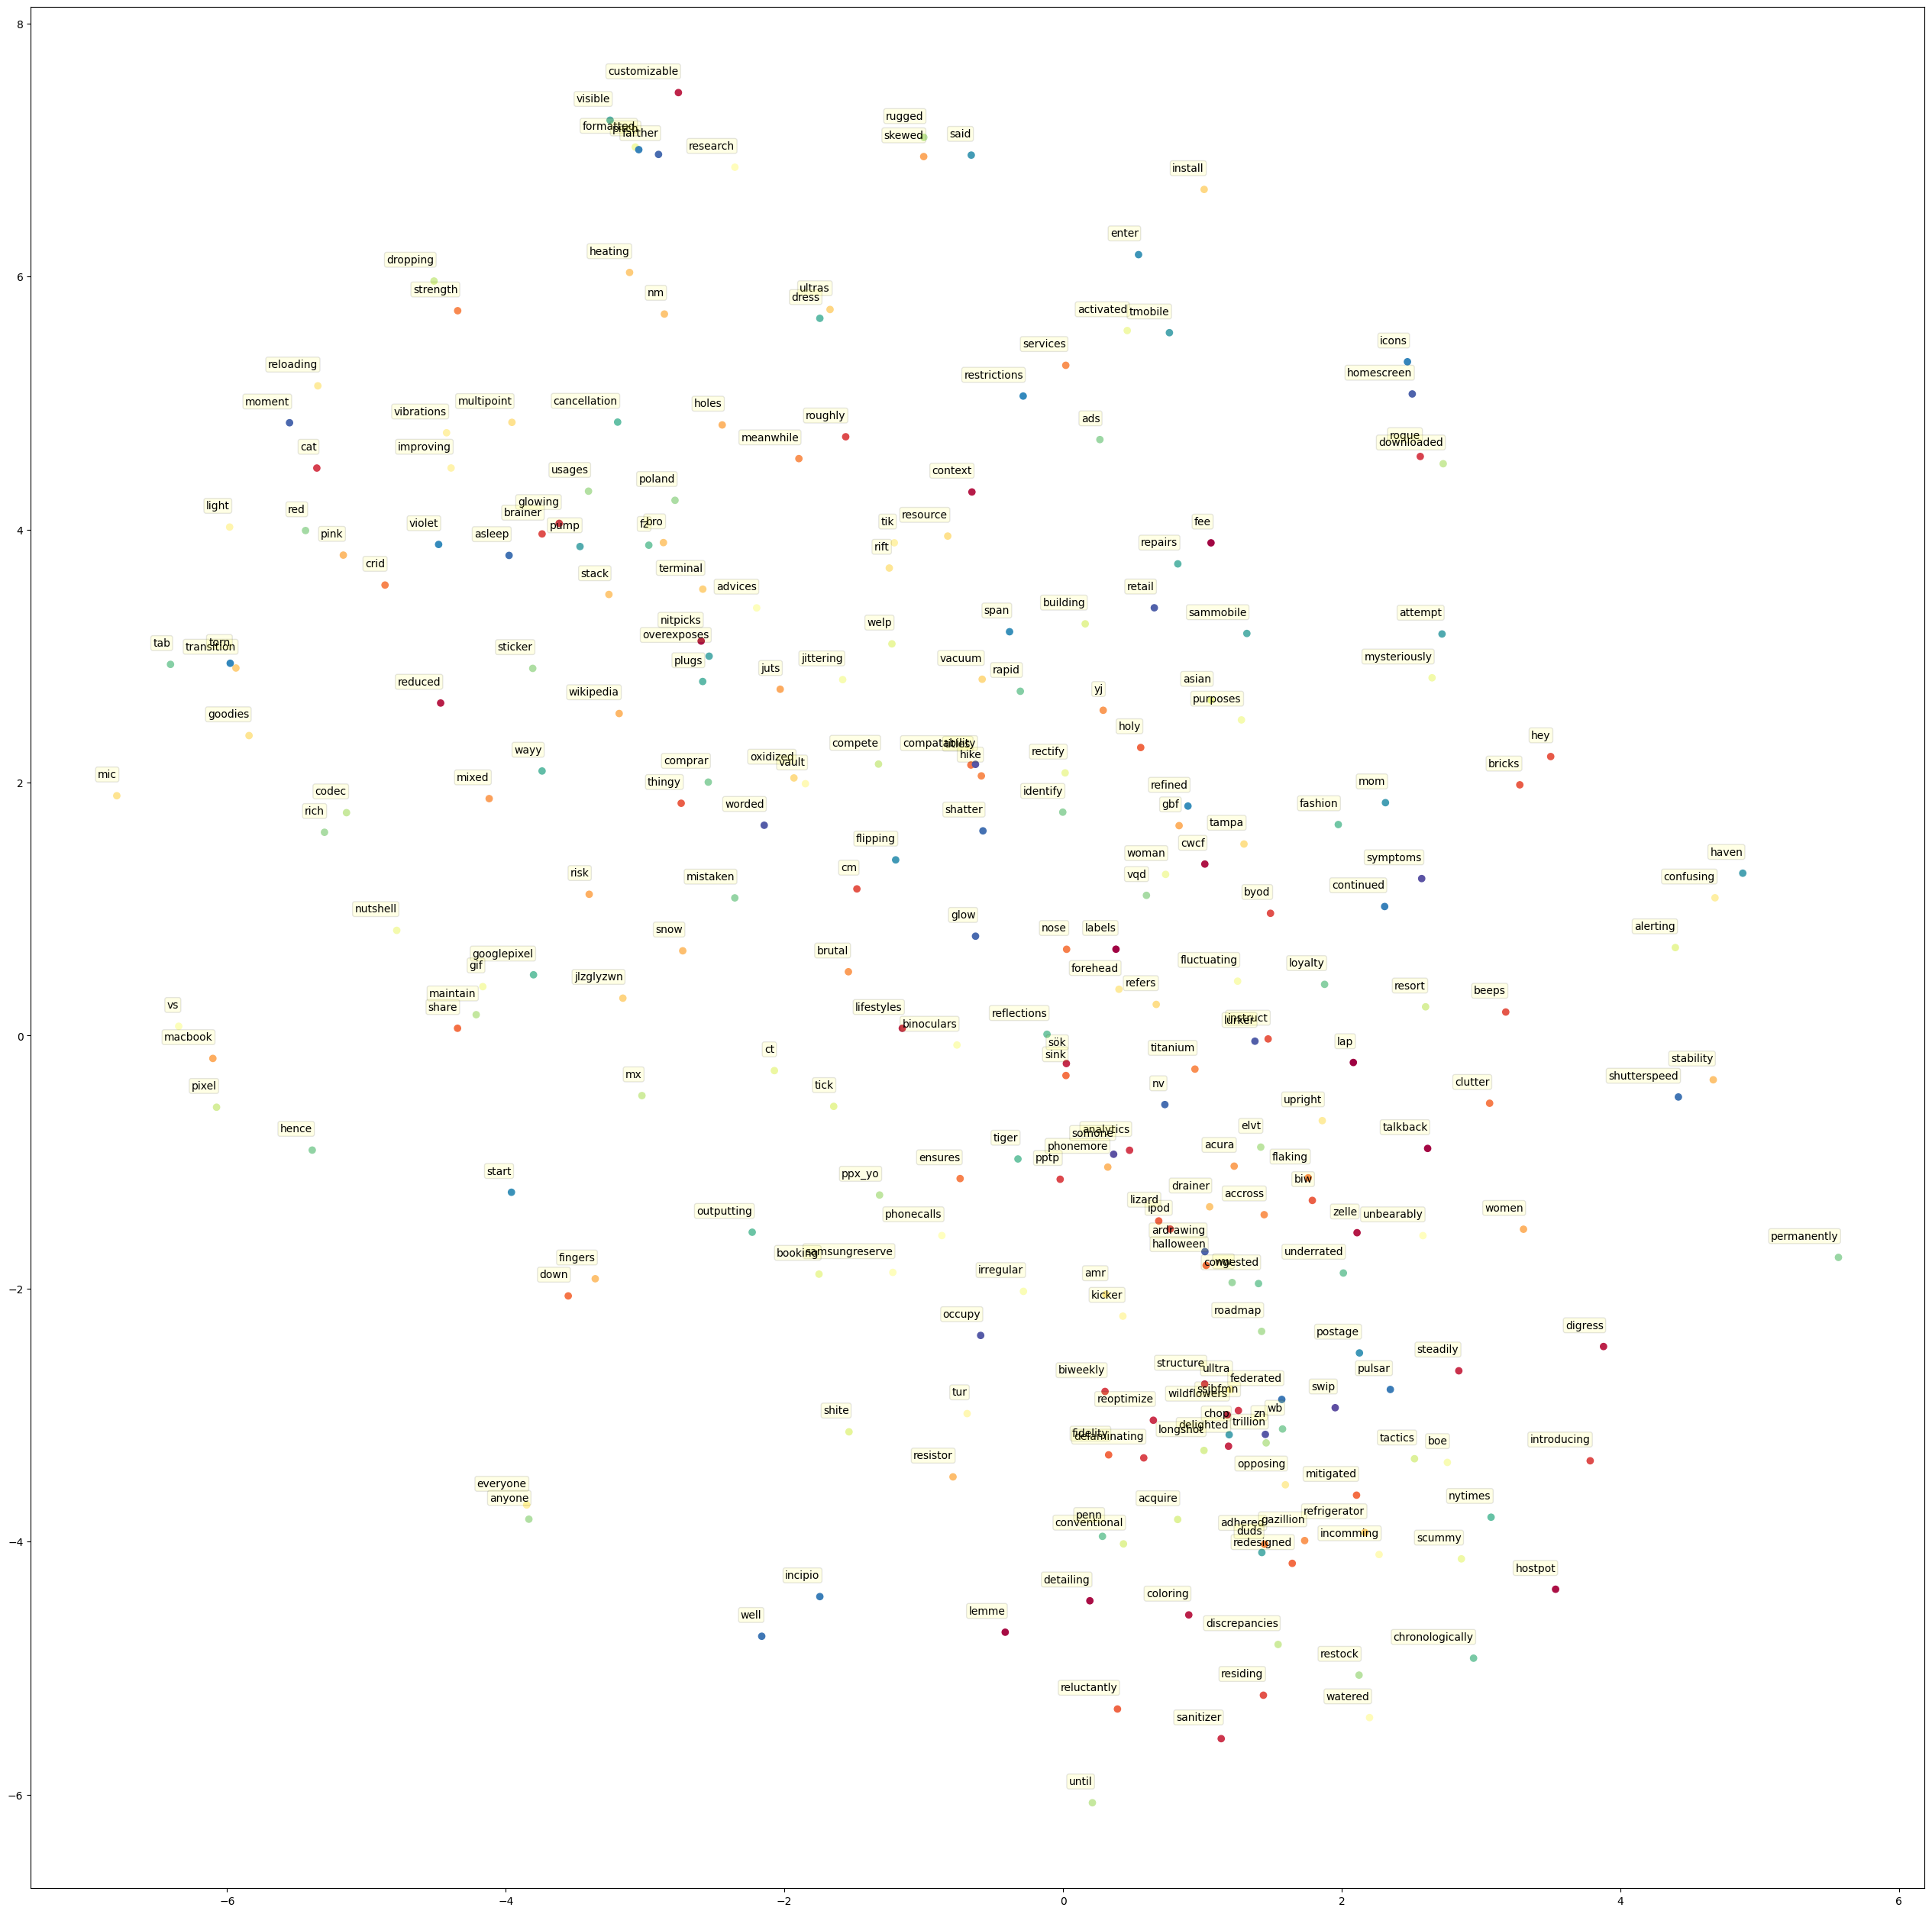

In [23]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,   # size of vectors desired
                                   window=5,          # number of words before & after target word to use as context
                                   min_count=15       # min_df
                                   )
w2v_model.build_vocab(X_train)                        # prepare the model vocabulary
w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
# w2v_model.wv.index_to_key                           # all words that Word2Vec model learned a vector for (with min_df=2)

# Find the most similar words to "king" based on word vectors from our trained model
# w2v_model.wv.most_similar('king')

# Visualizing Word2Vec Embeddings with t-SNE
semantic_similarity(X_train)


In [24]:
# Consider adding these pretty visuals for t-SNE

# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

In [25]:
# Create torch dataset
class VOC_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [26]:
!pip uninstall tokenizers, transformers, torch
!pip install tokenizers, transformers==4.27.4, torch==1.4.0 -U

# Note:

# Below error kept popping up when trying to run 'from transformers import TrainingArguments, Trainer' and 'from transformers import BertTokenizer, BertForSequenceClassification'
"""
RuntimeError: Failed to import transformers.training_args because of the following error (look up to see its traceback):
cannot import name 'is_torch_npu_available' from 'transformers.utils' (/usr/local/lib/python3.10/dist-packages/transformers/utils/__init__.py) site:stackoverflow.com
"""
# Found a work around by changing BertTokenizer into transformers.BertTokenizer and BertForSequenceClassification to transformers.BertForSequenceClassification

import torch
import transformers
import tokenizers
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
#from transformers import TrainingArguments, Trainer

#from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

ERROR: Invalid requirement: 'tokenizers,'
ERROR: Invalid requirement: 'tokenizers,'


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:
# model = model.to( torch.device('cuda') )     # need NVIDIA driver for 'cuda'; currently have AMD on work laptop
# model = model.to('cpu')         # train on CPU

model = model.to('cuda')          # or  model.cuda()

In [29]:
sample_data = ["This is possibly the worst battery I have ever seen on a mobile device",
            "How is my device running so smoothly?"]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[101, 2023, 2003, 4298, 1996, 5409, 6046, 1045, 2031, 2412, 2464, 2006, 1037, 4684, 5080, 102], [101, 2129, 2003, 2026, 5080, 2770, 2061, 15299, 1029, 102, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}

In [30]:
X_train, X_val, y_train, y_val = list(X_train), list(X_val), list(y_train), list(y_val)

In [31]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [32]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [33]:
print(X_train_tokenized['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [34]:
train_dataset = VOC_Dataset(X_train_tokenized, y_train)
val_dataset = VOC_Dataset(X_val_tokenized, y_val)

In [35]:
train_dataset[5]

{'input_ids': tensor([  101,  4041,  2000,  6942,  2000,  1055, 19317,  2013, 18059,  1012,
          2054,  2323,  1045,  2113,  2077,  2437,  1996,  5376,  1029,  1045,
          1521,  2310,  2042,  2478, 16380,  2005,  2485, 10930,  1020,  2086,
          2085,  1998,  1996,  2197, 11924,  1045,  2109,  2001,  2019,  2004,
          2271,  1998,  1996,  1055,  2475,  1048,  2863,  2080,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [36]:
def compute_metrics(m):
    print(type(m))
    pred, labels = m
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [37]:
# Define Trainer
args = transformers.TrainingArguments(       # from transformers import TrainingArguments spat our error so do transformers.TrainingArguments
    report_to = 'wandb',                     # enable logging to W&B
    output_dir="output",                     # output directory
    num_train_epochs=4,
    per_device_train_batch_size=8
    # overwrite_output_dir = True,
    # evaluation_strategy = 'steps',          # check evaluation metrics at each epoch
    # learning_rate = 5e-5,                   # we can customize learning rate
    # max_steps = 30000,
    # logging_steps = 100,                    # we will log every 100 steps
    # eval_steps = 5000,                      # we will perform evaluation every 500 steps
    # save_steps = 10000,
    # load_best_model_at_end = True,
    # metric_for_best_model = 'accuracy',
    # run_name = 'custom_training'            # name of the W&B run

)
trainer = transformers.Trainer(               # from transformers import Trainer spat our error so do transformers.Trainer
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,                 # for padding batched data
    compute_metrics=compute_metrics
)

In [38]:
# https://github.com/facebookresearch/fairseq/issues/1933
# https://huggingface.co/spaces/OFA-Sys/OFA-Generic_Interface/blob/8fc1d8aafce5821301443744696303bac6227f52/fairseq/examples/roberta/commonsense_qa/README.md

# PyTorch fairseq

MAX_UPDATES=2300      # Number of training steps, where   training step = training set / batch size. Originally 3000
WARMUP_UPDATES=150    # Linearly increase LR over this many steps
MAX_EPOCH=4           # Number of training epochs.
LR=1e-05              # Peak LR for fixed LR scheduler. 1e-05 default; try 1e-06 as initial LR
NUM_CLASSES=2
MAX_SENTENCES=8       # Batch size per GPU.
UPDATE_FREQ=32        # Accumulate gradients to simulate training on 8 GPUs.
DATA_DIR='VOC_final_output'
ROBERTA_PATH='/SiERoBERT_large/model.pt'

! CUDA_VISIBLE_DEVICES=0 fairseq-train $DATA_DIR --ddp-backend=no_c10d \
  --restore-file $ROBERTA_PATH \
  --reset-optimizer --reset-dataloader --reset-meters \
  --no-epoch-checkpoints --no-last-checkpoints --no-save-optimizer-state \
  #--best-checkpoint-metric accuracy --maximize-best-checkpoint-metric \
  --task sentence_ranking \
  --num-classes $NUM_CLASSES \
  --init-token 0 --separator-token 2 \
  --max-option-length 128 \
  --max-positions 512 \
  --truncate-sequence \
  --arch roberta_large \
  --dropout 0.1 --attention-dropout 0.1 --weight-decay 0.01 \
  --criterion sentence_ranking \
  --optimizer adam --adam-betas '(0.9, 0.98)' --adam-eps 1e-06 \
  --clip-norm 0.0 \
  --lr-scheduler fixed --lr $LR \
  --warmup-updates $WARMUP_UPDATES --total-num-update $MAX_UPDATES \
  --memory-efficient-fp16 --fp16-init-scale 4 --threshold-loss-scale 1 --fp16-scale-window 128 \
  --batch-size $MAX_SENTENCES \
  --required-batch-size-multiple 1 \
  --update-freq $UPDATE_FREQ \
  --max-epoch $MAX_EPOCH \
  --log-interval 100 \

# --memory-efficient-fp16 instead of --fp16 solves 'CUDA out of memory' problem, but slow training
# --max-sentences $MAX_SENTENCES , not batch-size
# --fp16-scale-window 128 default

/bin/bash: line 1: fairseq-train: command not found


In [39]:
# clear cache before training
torch.cuda.empty_cache()

In [40]:
trainer.train()

wandb: Currently logged in as: ojw92. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.412900
1000,0.359400
1500,0.309900
2000,0.313300
2500,0.312900
3000,0.303300
3500,0.283100
4000,0.261900
4500,0.251900
5000,0.262200


TrainOutput(global_step=13016, training_loss=0.2137704744394674, metrics={'train_runtime': 10312.74, 'train_samples_per_second': 10.095, 'train_steps_per_second': 1.262, 'total_flos': 2.739301819564032e+16, 'train_loss': 0.2137704744394674, 'epoch': 4.0})

In [41]:
trainer.evaluate()


<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.5022413730621338,
 'eval_accuracy': 0.8980297269270653,
 'eval_precision': 0.7967257844474761,
 'eval_recall': 0.8,
 'eval_f1': 0.7983595352016406,
 'eval_runtime': 100.1668,
 'eval_samples_per_second': 28.882,
 'eval_steps_per_second': 3.614,
 'epoch': 4.0}

In [42]:
np.set_printoptions(suppress=True)


In [43]:
text = "Super charging is working very well."
# text = "so many issues with this phone."
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)    # also gelu(), silu()
print(predictions)
predictions = predictions.cpu().detach().numpy()
predictions

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.1105, -3.8922]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[9.9967e-01, 3.3444e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


array([[0.9996656 , 0.00033444]], dtype=float32)

In [44]:
trainer.save_model('BertPractice')

In [45]:
# trainer.save_model('/content/drive/MyDrive/Youtube Tutorials/toxic')
# model_2 = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Youtube Tutorials/toxic")
# model_2.to('cuda')

In [46]:
model_2 = transformers.BertForSequenceClassification.from_pretrained('BertPractice')
model_2.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [47]:
# text = "Super charging is working very well."
text = "so many issues with this phone."
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions

array([[0.01171322, 0.9882868 ]], dtype=float32)

In [55]:
# Evaluate performance on validation set in this cell



# val_dataset
"""
from datasets import load_dataset
dataset = load_dataset('imdb')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
small_eval_dataset
"""
print(small_eval_dataset)
print(val_dataset)


Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


[8.1710634e-05, 0.002286566, 0.9923382, 6.746248e-05, 5.7348756e-05, 0.00046803913, 0.9925808, 6.503002e-05, 0.99384236, 0.9847743, 0.99386394, 5.793526e-05, 6.2981926e-05, 0.00016410391, 5.8327743e-05, 0.0034415643, 0.9940327, 6.722917e-05, 8.236574e-05, 0.99388194, 6.0936003e-05, 0.00029169663, 0.005201114, 7.292412e-05, 0.9877198, 0.9652582, 5.957436e-05, 0.9919904, 6.2298444e-05, 0.9679929, 0.0001653025, 0.00066796894, 0.00025951676, 0.00038666432, 0.00012067334, 5.6294215e-05, 0.0011200706, 7.5249e-05, 6.0604747e-05, 0.989833, 0.0013069578, 7.6053366e-05, 5.824959e-05, 0.9915856, 0.00022462744, 0.99296725, 0.9914756, 0.9930548, 8.507567e-05, 0.0005568834, 5.7451332e-05, 6.564248e-05, 8.07097e-05, 0.014639154, 0.9924941, 7.0591996e-05, 8.410857e-05, 6.012506e-05, 6.0548136e-05, 7.364013e-05, 0.9875238, 6.168906e-05, 6.0204642e-05, 5.865818e-05, 6.2090505e-05, 0.9929454, 7.178958e-05, 0.99322116, 9.67088e-05, 0.00089375983, 0.0046796077, 0.98301345, 8.450894e-05, 6.4999906e-05, 0.00

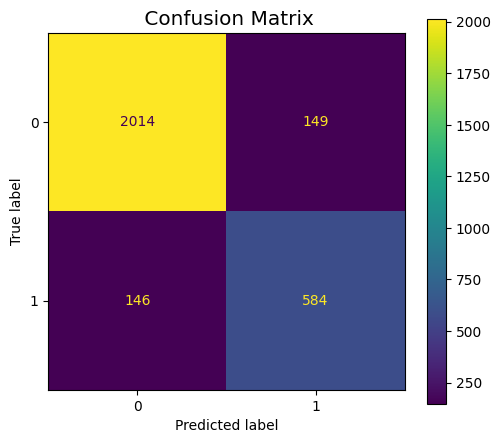

AUC :  0.9474638851417677


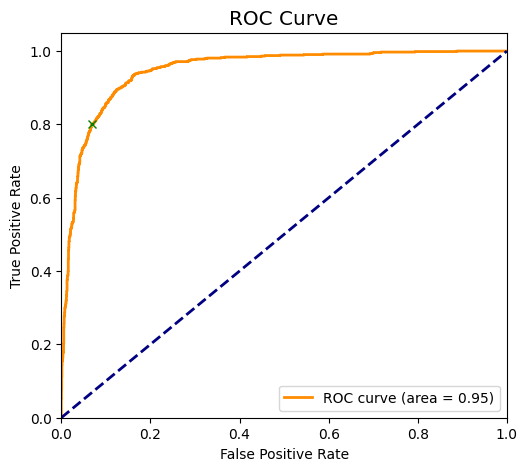

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

"""
da_preds = pd.DataFrame({
          "Text" : X_val,
          "Class" : y_val})
da_preds = pred_day(da_preds)
"""
"""
da_predso = list()
for x in da_preds['Prediction']:
  if round(x[0][0]) == 1:
    da_predso.append(0)
  elif round(x[0][1]) == 1:
    da_predso.append(1)
print(da_predso)
"""
da_predsooo = [x[0][1] for x in da_preds['Prediction']]
print(da_predsooo)



def confusion_matrix_display(y_test, y_pred, filename=None, directory=None):
    # inputs: actual labels & prediction labels
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    cm = confusion_matrix(y_test, y_pred)     # labels=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)     # display_labels=clf.classes_
    disp.plot()
    if filename is None:
        filename = ""
    plt.title(f'{filename[10:-4]} Confusion Matrix')     # test_data/test_1012.csv --> test_1012
    plt.show()

    if directory is not None:
        # save plot to directory
        f = os.path.join(directory, filename[10:-4])
        plt.savefig(f'{f}-confmat.png')

    return tn, fp, fn, tp


# Create ROC curve and compute AUC
def ROC_AUC(y_test, y_score, fpr_tpr=None):
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)    # 'thresholds' go in '_'
    roc_auc = auc(fpr, tpr)
    #print('fpr is', fpr)
    #print('tpr is', tpr)
    #print('thresholds', thresholds)
    print('AUC : ', roc_auc)

    # ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange",
        lw=lw, label="ROC curve (area = %0.2f)" % roc_auc,)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    if fpr_tpr is not None:
        plt.plot(fpr_tpr[0], fpr_tpr[1], color="green", lw = 3, marker='x')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



# Create ROC curve and compute AUC for test data
tn, fp, fn, tp = confusion_matrix_display(y_val, da_predso)
fpr_tpr = [fp/(fp+tn), tp/(tp+fn)]
ROC_AUC(y_val, da_predsooo, fpr_tpr)

In [85]:
"""
# Use the results from validation set to create a confusion matrix and ROC curve

from sklearn.metrics import confusion_matrix, roc_curve, auc

# Reference: https://towardsdatascience.com/practical-introduction-to-transformer-models-bert-4715ed0deede
# Evaluation
predictions = trainer.predict(val_dataset)

# Confusion matrix
cm = confusion_matrix(val_dataset['label'], predictions.predictions.argmax(-1))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(val_dataset['label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(1.618 * 5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
"""

'\n# Use the results from validation set to create a confusion matrix and ROC curve\n\nfrom sklearn.metrics import confusion_matrix, roc_curve, auc\n\n# Reference: https://towardsdatascience.com/practical-introduction-to-transformer-models-bert-4715ed0deede\n# Evaluation\npredictions = trainer.predict(val_dataset)\n\n# Confusion matrix\ncm = confusion_matrix(val_dataset[\'label\'], predictions.predictions.argmax(-1))\nsns.heatmap(cm, annot=True, fmt=\'d\')\nplt.title(\'Confusion Matrix\')\nplt.show()\n\n# ROC Curve\nfpr, tpr, _ = roc_curve(val_dataset[\'label\'], predictions.predictions[:, 1])\nroc_auc = auc(fpr, tpr)\n\nplt.figure(figsize=(1.618 * 5, 5))\nplt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=\'ROC curve (area = %0.2f)\' % roc_auc)\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver operating characteristic\')\nplt.leg

In [ ]:
# Use the results to choose a threshold?



In [86]:
# Make predictions on daily data

def pred_day(voctoday):
  voclist = list(voctoday['Text'])
  predlist = []

  for i in range(len(voclist)):
    inputs = tokenizer(voclist[i], padding = True, truncation = True, return_tensors='pt').to('cuda')
    outputs = model_2(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions = predictions.cpu().detach().numpy()
    predlist.append(predictions)

  organizedzip = zip([x[:50] for x in voclist],
                    predlist,
                    voctoday['Class'])

  # results as voc text, predictions, and actual value
  vocresult = pd.DataFrame(list(organizedzip), columns=['Text','Prediction','Actual'])

  return vocresult


In [89]:
# test VOC
# import file and combine title & content

# test VOC for 8/14 (Mon) - 8/16 (Wed) using model trained on ~8/11 (Fri) data

voc814 = pd.read_csv('814testraw.csv', index_col=0, delimiter=",").drop_duplicates()     # use delimiter ',' for original .csv file created from my test file generator
voc814 = data_concat(voc814.loc[: , 'Title':'Class'])

voc815 = pd.read_csv('815testraw.csv', index_col=0, delimiter=",").drop_duplicates()
voc815 = data_concat(voc815.loc[: , 'Title':'Class'])

voc816 = pd.read_csv('816testraw.csv', index_col=0, delimiter=",").drop_duplicates()
voc816 = data_concat(voc816.loc[: , 'Title':'Class'])

voc817 = pd.read_csv('817testraw.csv', index_col=0, delimiter=",").drop_duplicates()
voc817 = data_concat(voc817.loc[: , 'Title':'Class'])

voc818 = pd.read_csv('818testraw.csv', index_col=0, delimiter=",").drop_duplicates()
voc818 = data_concat(voc818.loc[: , 'Title':'Class'])

voc821 = pd.read_csv('821testraw.csv', index_col=0, delimiter=",").drop_duplicates()
voc821 = data_concat(voc821.loc[: , 'Title':'Class'])

voc831 = pd.read_csv('831testraw.csv', index_col=0, delimiter=",").drop_duplicates()
voc831 = data_concat(voc831.loc[: , 'Title':'Class'])


In [90]:
vocresult814 = pred_day(voc814)
vocresult814

,Text,Prediction,Actual
0,Please help s22 vs S23. Should I pay the extra...,"[[0.99992764, 7.235763e-05]]",0
1,Trade in question - screen issue My s22 ultra ...,"[[0.9990941, 0.0009058439]]",1
2,Routine How could I change the mode on my phon...,"[[0.9997632, 0.00023680972]]",0
3,S22 ultra root. I've been trying to root my s2...,"[[0.99987745, 0.00012254492]]",0
4,S22Ultra Cases and Whitestone FOR SALE\n\nSwit...,"[[0.99992764, 7.2310926e-05]]",0
5,Fast Charging suddenly stopped working &amp; c...,"[[0.0073410855, 0.9926589]]",0
6,"Super Fast Charging 2.0 Hi, I have an S22 Ultr...","[[0.013583461, 0.9864166]]",0
7,Broken Screen. Options? Cracked my screen wee...,"[[0.9977464, 0.0022536137]]",1
8,S22u green bar on camera issue is happening. I...,"[[0.007087195, 0.9929128]]",1
9,"Planing To Move To IOS Hello everyone, I'd lik...","[[0.99984, 0.00015996133]]",0


In [91]:
vocresult815 = pred_day(voc815)
vocresult815

,Text,Prediction,Actual
0,Currently using s22 ultra and thinking of swit...,"[[0.9999298, 7.0166694e-05]]",0
1,Any reason why is S23 series behind S22 in upd...,"[[0.99983037, 0.0001696094]]",0
2,Routine not running at specified time I have a...,"[[0.0070923506, 0.99290764]]",1
3,Wifi issue on s22 ultra My wifi randomly disco...,"[[0.0061052484, 0.99389476]]",1
4,Camera lag Generally I feel like the camera ap...,"[[0.006099718, 0.9939003]]",1
5,Phones unable to keep up. I have started notic...,"[[0.006822068, 0.9931779]]",1
6,Screen issue (blinking pixel?) As seen in the ...,"[[0.00741599, 0.992584]]",1
7,Looking For Good Grip Slim Case Any Recommende...,"[[0.999943, 5.696862e-05]]",0
8,Change microphone source input Hi\n\nWhen I'm ...,"[[0.9993062, 0.0006938524]]",0
9,Recent WiFi Troubles Have a bit of a weird iss...,"[[0.0065022483, 0.9934977]]",1


In [92]:
vocresult816 = pred_day(voc816)
vocresult816

,Text,Prediction,Actual
0,Deals on new S22? I'm trading my fold 4 if tha...,"[[0.9999213, 7.862263e-05]]",0
1,Reception Issues: IF YOU HAVE WARRANTY (24 mon...,"[[0.99491715, 0.0050828066]]",0
2,Stutters I recently got an Unlocked Verizon S2...,"[[0.9941614, 0.005838499]]",1
3,"Data Recovery from Broken Phone Hey all,\n\nSo...","[[0.9998511, 0.00014889556]]",0
4,S22 ultra is good? Switching to Fold 5 will be...,"[[0.99992514, 7.490692e-05]]",0
5,Replacement keeps randomly shutting off Had to...,"[[0.005933679, 0.99406636]]",1
6,Question I bought my s22 ultra late last year ...,"[[0.99992216, 7.782901e-05]]",0
7,Letterboxing on Windows slideshow I put the fi...,"[[0.9997254, 0.00027453396]]",0
8,Is the official Galaxy Tab S4 keyboard case be...,"[[0.9999311, 6.8868e-05]]",0
9,"Gifs Sooo my wife and I have the same phone, w...","[[0.9844493, 0.01555061]]",0


In [93]:
vocresult817 = pred_day(voc817)
vocresult817

,Text,Prediction,Actual
0,Is this snapdragon or exynos,"[[0.9999434, 5.667212e-05]]",0
1,"Bought a S22 Ultra second hand, in excellent c...","[[0.9999254, 7.465904e-05]]",0
2,Upgrade device I got an offer from the insuran...,"[[0.9999355, 6.445721e-05]]",0
3,Weird background music randomly playing,"[[0.009089404, 0.9909106]]",1
4,"The speaker placement on the ""note"" devices af...","[[0.22490433, 0.7750957]]",1
5,max number of esims installed? anybody know wh...,"[[0.9999201, 7.9897e-05]]",0
6,Other people getting holes in their pants from...,"[[0.99987507, 0.00012493276]]",0
7,No Wifi Calling option Company recently starte...,"[[0.999747, 0.00025304733]]",1
8,Overheating and battery life is bad I just got...,"[[0.006492706, 0.99350727]]",1
9,Phone cases for the S22 Ultra that support NFC...,"[[0.99992347, 7.6530545e-05]]",0


In [94]:
vocresult818 = pred_day(voc818)
vocresult818

,Text,Prediction,Actual
0,Shoot the shot or not? I have the chance to ge...,"[[0.9999341, 6.597717e-05]]",0
1,Pre-installed mcafee So my s22 ultra have alre...,"[[0.99982244, 0.00017757117]]",0
2,"Screen wakes up in pocket Hi all, \n\nI have w...","[[0.006622974, 0.99337703]]",0
3,What would you do? I just upgraded to a S22 ul...,"[[0.9999206, 7.942026e-05]]",0
4,Telephoto cameras Every spec sheet I see says ...,"[[0.99978966, 0.0002103848]]",0
5,S22U Vs S23 + Hello. I have an option to buy t...,"[[0.9999379, 6.2124505e-05]]",0
6,I guess I got lucky with my S22 SD My S22 base...,"[[0.9998067, 0.00019335731]]",0
7,S22 Microphone issue So I recently got an S22 ...,"[[0.99994206, 5.7881694e-05]]",0
8,Which Font Size and Screen Zoom settings do yo...,"[[0.9998858, 0.000114168644]]",0
9,USB-C problem S22 I don’t remember if i have a...,"[[0.99835855, 0.0016414383]]",0


In [95]:
vocresult821 = pred_day(voc821)
vocresult821

,Text,Prediction,Actual
0,Is this even possible with last year s22? 56% ...,"[[0.98919094, 0.010809104]]",0
1,"S22+ battery is $h*t, go to S23+? Probably bee...","[[0.9994686, 0.0005313521]]",1
2,Can't update apps with wifi Despite having no ...,"[[0.0075805914, 0.9924194]]",1
3,Dex only works when connected to power I've ha...,"[[0.008688548, 0.99131143]]",1
4,Cracked trade in question I was recently debat...,"[[0.99992776, 7.219607e-05]]",0
5,Status bar burn-in Anyone else having burn-in ...,"[[0.009859971, 0.99014]]",0
6,"in a day to day scenario, does anyone else use...","[[0.9996836, 0.0003163862]]",0
7,How can I get this clock on my lockscreen and ...,"[[0.99836856, 0.0016314985]]",0
8,Refurbished 22ultra vs fixing current? So I go...,"[[0.9930815, 0.0069185]]",1
9,!!PLEASE HELP!! (I'm in a panicking situation ...,"[[0.024667587, 0.97533244]]",1


In [96]:
vocresult831 = pred_day(voc831)
vocresult831

,Text,Prediction,Actual
0,My camera won't record video longer than 8 min...,"[[0.005993565, 0.9940064]]",1
1,Smartview for laptop connection not working Is...,"[[0.006191863, 0.9938081]]",1
2,"Secure Folder trf/backup Can we trf files, pho...","[[0.9998523, 0.00014766447]]",0
3,I need help with this secure folder So I'm usi...,"[[0.04431225, 0.9556878]]",1
4,I need help with this secure folder So I'm usi...,"[[0.04431225, 0.9556878]]",1
5,Hi everyone I just had a question about the sc...,"[[0.99983025, 0.00016972669]]",0
6,Anyone else already getting screen burn in ? A...,"[[0.02638883, 0.97361124]]",1
7,"Clean front speaker Hi rveryone, i noticed tha...","[[0.8558357, 0.1441643]]",0
8,What Messages app you're using? I'm actually u...,"[[0.99978715, 0.00021286949]]",0
9,"Asking for Basic (Auto, not Pro) Camera Photo ...","[[0.99988663, 0.00011334522]]",0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5caba9f-cd36-4d50-aaa3-2cf59957a2f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>